In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import json
import os
import yaml
from dask.distributed import Client

In [4]:
with open('/g/g92/haridev/.dlio_profiler/configuration.yaml', 'r') as file:
    dlp_yaml = yaml.safe_load(file)

In [5]:
# to make this notebook in dev mode.
import sys
sys.path.insert(0,dlp_yaml["APP"])
sys.path

['/usr/WS2/haridev/dlio-profiler',
 '/usr/WS2/haridev/dlio-profiler/examples/dlp_analyzer',
 '/usr/WS2/haridev/dlio-profiler/examples/dlp_analyzer',
 '/usr/workspace/iopp/projects/digio',
 '/collab/usr/gapps/python/build/spack-toss4.1/var/spack/environments/python/._view/75prb56irmif5ejtirjthpx6kq3gqo52/lib/python39.zip',
 '/collab/usr/gapps/python/build/spack-toss4.1/var/spack/environments/python/._view/75prb56irmif5ejtirjthpx6kq3gqo52/lib/python3.9',
 '/collab/usr/gapps/python/build/spack-toss4.1/var/spack/environments/python/._view/75prb56irmif5ejtirjthpx6kq3gqo52/lib/python3.9/lib-dynload',
 '',
 '/usr/WS2/haridev/venvs/venv-dlp_analuzer/lib/python3.9/site-packages']

In [6]:
import dlp_analyzer
print(dlp_analyzer.__file__)
from dlp_analyzer.main import DLPAnalyzer,get_dlp_configuration,update_dlp_configuration,setup_logging,setup_dask_cluster, reset_dask_cluster, get_dlp_configuration

/usr/WS2/haridev/dlio-profiler/dlp_analyzer/__init__.py


In [7]:
dask_run_dir = os.path.join(dlp_yaml["APP"], "dlp_analyzer", "dask", "run_dir")
dask_run_dir

'/usr/WS2/haridev/dlio-profiler/dlp_analyzer/dask/run_dir'

In [8]:
with open (os.path.join(dask_run_dir, "scheduler.json"), "r") as f:
    dask_scheduler = json.load(f)
dask_scheduler

{'type': 'Scheduler',
 'id': 'Scheduler-89209c3b-66f7-4b23-9420-c0d0848be547',
 'address': 'tcp://134.9.71.27:10001',
 'services': {'dashboard': 8787},
 'started': 1698518019.2896266,
 'workers': {}}

In [9]:
app_name = "deepspeed" # resnet cosmoflow unet3d mummi deepspeed

In [10]:
def get_conditions_cosmoflow(json_object):
    app_io_cond = "TFReader.parse_image" in json_object["name"] # Cosmoflow
    compute_cond = "compute" in json_object["name"] # Cosmoflow
    io_cond = "POSIX" == json_object["cat"] # Cosmoflow
    return app_io_cond, compute_cond, io_cond

def get_conditions_resnet(json_object):
    app_io_cond = "IO" == json_object["cat"] # Resnet50
    compute_cond = "cpu" in json_object["name"] or "compute" in json_object["cat"] # Resnet50
    io_cond = "POSIX" == json_object["cat"] # Cosmoflow
    return app_io_cond, compute_cond, io_cond

def get_conditions_unet3d(json_object):
    app_io_cond = "NPZReader.read_index" in json_object["name"] # Unet3d
    compute_cond = "compute" in json_object["name"] # Unet3d
    io_cond = "POSIX" == json_object["cat"] # Cosmoflow
    return app_io_cond, compute_cond, io_cond


In [11]:
condition_fn = None
if app_name == "cosmoflow":
    filename = "/usr/WS2/iopp/kogiou1/dlio_benchmark/hydra_log/cosmoflow/2023-10-31-10-27-24/.trace*.pfw.gz"
    condition_fn = get_conditions_cosmoflow
elif app_name == "resnet":
    filename = "/usr/workspace/iopp/dlio_paper_results/resnet_50_1node_4ppn/*.pfw.gz"
    condition_fn = get_conditions_resnet
elif app_name == "unet3d":
    filename = "/usr/workspace/iopp/kogiou1/dlio_benchmark_logs/unet3d/node_32_ppn_4/.trace*.pfw.gz"
    condition_fn = get_conditions_unet3d
elif app_name == "mummi":
    filename = "/usr/workspace/iopp/dlp_traces/mummi-32-node/trace*.pfw.gz"
elif app_name == "deepspeed":
    filename = "/usr/workspace/iopp/dlp_traces/deepspeed_8_4ppn/*.pfw.gz"
else:
    raise Exception("Unknown App name")

In [12]:
conf = update_dlp_configuration(dask_scheduler=dask_scheduler["address"], verbose=True, 
                                log_file="./dlp.log", rebuild_index=False, time_approximate=True, 
                                host_pattern=r'lassen(\d+)', time_granularity=3600e6, skip_hostname=True, conditions=condition_fn)


In [13]:
conf = get_dlp_configuration()
conf.time_approximate

True

In [14]:
setup_logging()

In [15]:
setup_dask_cluster()

[INFO] [08:18:06] Initialized Client with 48 workers and link http://134.9.71.27:8787/status [/usr/WS2/haridev/dlio-profiler/dlp_analyzer/main.py:625]


In [16]:
reset_dask_cluster()

[INFO] [08:18:12] Restarting all workers [/usr/WS2/haridev/dlio-profiler/dlp_analyzer/main.py:617]


In [17]:
analyzer = DLPAnalyzer(filename)

[INFO] [08:18:15] Created index for 32 files [/usr/WS2/haridev/dlio-profiler/dlp_analyzer/main.py:333]
[INFO] [08:18:15] Total size of all files are <dask.bag.core.Item object at 0x1554a7c6e790> bytes [/usr/WS2/haridev/dlio-profiler/dlp_analyzer/main.py:335]
[INFO] [08:18:15] Loading 32 batches out of 32 files and has 82022 lines overall [/usr/WS2/haridev/dlio-profiler/dlp_analyzer/main.py:348]
[INFO] [08:18:17] Loaded events [/usr/WS2/haridev/dlio-profiler/dlp_analyzer/main.py:390]
[INFO] [08:18:17] Loaded plots with slope threshold: 45 [/usr/WS2/haridev/dlio-profiler/dlp_analyzer/main.py:396]


In [18]:
analyzer.events.head()

,name,cat,pid,tid,ts,te,dur,tinterval,trange,hostname,compute_time,io_time,app_io_time,total_time,filename,phase,size
0,open64,POSIX,119809,239618,1667,1707,40,<NA>,0.0,lassen464,<NA>,40,<NA>,40,<NA>,2,<NA>
1,__fxstat64,POSIX,119809,239618,1934,1938,4,<NA>,0.0,lassen464,<NA>,4,<NA>,4,<NA>,2,<NA>
2,lseek64,POSIX,119809,239618,2088,2094,6,<NA>,0.0,lassen464,<NA>,6,<NA>,6,<NA>,2,<NA>
3,lseek64,POSIX,119809,239618,2244,2250,6,<NA>,0.0,lassen464,<NA>,6,<NA>,6,<NA>,2,<NA>
4,__fxstat64,POSIX,119809,239618,2373,2377,4,<NA>,0.0,lassen464,<NA>,4,<NA>,4,<NA>,2,<NA>


In [19]:
#analyzer.events[["io_time","compute_time","app_io_time"]].max().compute() / 1e6

In [20]:
items = analyzer.summary()
items

[INFO] [08:18:28] Total number of events in the workload are 81990 [/usr/WS2/haridev/dlio-profiler/dlp_analyzer/main.py:488]
/usr/WS2/haridev/venvs/venv-dlp_analuzer/lib/python3.9/site-packages/dask/dataframe/core.py:5983: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=(None, 'int64'))

  warnings.warn(meta_warning(meta))
/usr/WS2/haridev/venvs/venv-dlp_analuzer/lib/python3.9/site-packages/dask/dataframe/core.py:5983: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provi

╭──────────────────────────────────────────────────── Summary ────────────────────────────────────────────────────╮
│  Allocation    Scheduler Allocation Details                                                                     │
│                ├── Nodes: 8 ['lassen464', 'lassen637', 'lassen480', 'lassen481', 'lassen135', 'lassen141',      │
│                │   'lassen470', 'lassen308']                                                                    │
│                ├── Processes: 32 [22611,90232] | [119809,132172]                                                │
│                ├── Thread allocations across nodes (includes dynamically created threads)                       │
│                │   ├── Compute: 0                                                                               │
│                │   └── I/O: 32                                                                                  │
│                └── Events Recorded: 81990                                                                       │
│  Dataset       Description of Dataset Used                                                                      │
│                └── Files: 1 ['<NA>']                                                                            │
│  I/O Behavior  Behavior of Application                                                                          │
│                ├── Split of Time in application                                                                 │
│                │   ├── Total Time: 42118.183 sec                                                                │
│                │   ├── Overall App Level I/O: 0.000 sec                                                         │
│                │   ├── Unoverlapped App I/O: 0.000 sec                                                          │
│                │   ├── Unoverlapped App Compute: 0.000 sec                                                      │
│                │   ├── Compute: 0.000 sec                                                                       │
│                │   ├── Overall I/O: 179.667 sec                                                                 │
│                │   ├── Unoverlapped I/O: 179.667 sec                                                            │
│                │   └── Unoverlapped Compute: 0.000 sec                                                          │
│                ├── Transfer size distribution by function                                                       │
│                │   ├── Function       |min   |25    |mean  |median|75    |max   |                               │
│                │   ├── open64         |NA    |nan   |nan   |NA    |nan   |NA    |                               │
│                │   ├── __fxstat64     |NA    |nan   |nan   |NA    |nan   |NA    |                               │
│                │   ├── lseek64        |NA    |nan   |nan   |NA    |nan   |NA    |                               │
│                │   ├── read           |NA    |445KB |6MB   |1016KB|16MB  |16MB  |                               │
│                │   ├── close          |NA    |nan   |nan   |NA    |nan   |NA    |                               │
│                │   ├── __xstat64      |NA    |nan   |nan   |NA    |nan   |NA    |                               │
│                │   ├── fcntl          |NA    |nan   |nan   |NA    |nan   |NA    |                               │
│                │   ├── mmap64         |NA    |nan   |nan   |NA    |nan   |NA    |                               │
│                │   ├── mkdir          |NA    |nan   |nan   |NA    |nan   |NA    |                               │
│                │   └── write          |15    |11KB  |110MB |12MB  |50MB  |963MB |                               │
│                └── Event count by function                                                                      │
│                    ├── open64 : 6883                  

In [21]:
analyzer.events.groupby("name")["size"].sum().compute() / 1024**3

name
__fxstat64       0.000000
__xstat64        0.000000
close            0.000000
fcntl            0.000000
lseek64          0.000000
mkdir            0.000000
mmap64           0.000000
model.save       0.000000
open64           0.000000
read             1.712643
torch.save       0.000000
write         4629.080253
Name: size, dtype: double[pyarrow]

In [22]:
analyzer.events.groupby(["trange","pid","tid", "name"])["io_time"].sum().groupby(["trange", "name"]).max().groupby([ "name"]).sum().compute() / 1e6

name
__fxstat64      0.001024
__xstat64      34.468904
close           0.107129
fcntl           0.000042
lseek64         0.002075
mkdir          52.807408
mmap64          0.000851
model.save      0.000000
open64         47.426330
read            0.499186
torch.save      0.000000
write         118.566214
Name: io_time, dtype: double[pyarrow]

In [23]:
analyzer.events.groupby(["trange","pid","tid", "name"])["io_time"].count().groupby(["trange", "name"]).sum().groupby([ "name"]).sum().compute()

name
__fxstat64     7035
__xstat64      5835
close          6963
fcntl            88
lseek64        7230
mkdir          3161
mmap64           88
model.save        0
open64         6883
read            280
torch.save        0
write         43299
Name: io_time, dtype: int64[pyarrow]

In [24]:
timeline = analyzer.plots._create_timeline( analyzer.events).compute()

/usr/WS2/haridev/venvs/venv-dlp_analuzer/lib/python3.9/site-packages/dask/dataframe/shuffle.py:1032: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  mins = mins.fillna(method="bfill").tolist()
/usr/WS2/haridev/venvs/venv-dlp_analuzer/lib/python3.9/site-packages/dask/dataframe/shuffle.py:1033: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  maxes = maxes.fillna(method="bfill").tolist()


In [25]:
timeline

,phase,index,size,io_time,app_io_time
trange,,,,,
0.0,2,280,1838936288,503210,0
1.0,2,4811,552270785909,12768656,0
1.0,0,0,0,0,0
2.0,2,4811,552270785909,14494670,0
2.0,0,0,0,0,0
3.0,2,4811,552270785909,10240608,0
3.0,0,0,0,0,0
4.0,2,4811,552270785909,13608161,0
4.0,0,0,0,0,0


/usr/WS2/haridev/venvs/venv-dlp_analuzer/lib/python3.9/site-packages/dask/dataframe/shuffle.py:1032: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  mins = mins.fillna(method="bfill").tolist()
/usr/WS2/haridev/venvs/venv-dlp_analuzer/lib/python3.9/site-packages/dask/dataframe/shuffle.py:1033: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  maxes = maxes.fillna(method="bfill").tolist()


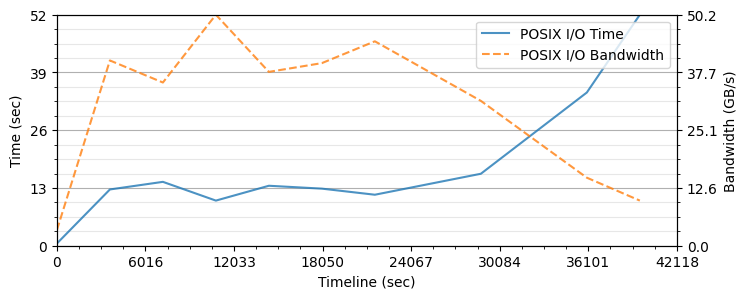

In [26]:
fig, ax1, ax2 = analyzer.plots.time_bw_timeline(
    bw_unit='gb',
    figsize=(8, 3),
    line1_label='POSIX I/O Time',
    line2_label='POSIX I/O Bandwidth',
    time_col='io_time',
    x_num_ticks=8,
    y_num_ticks=5,
)

In [27]:
fig.savefig(f'{app_name}_posix_io_time.pdf', format='pdf', bbox_inches='tight')

In [ ]:
fig, ax1, ax2 = analyzer.plots.time_bw_timeline(
    bw_unit='kb',
    figsize=(8, 3),
    line1_label='App. I/O Time',
    line2_label='App. I/O Bandwidth',
    time_col='app_io_time',
    x_num_ticks=8,
    y_num_ticks=5,
)

In [ ]:
fig.savefig(f'{app_name}_app_io_time.pdf', format='pdf', bbox_inches='tight')

/usr/WS2/haridev/venvs/venv-dlp_analuzer/lib/python3.9/site-packages/dask/dataframe/shuffle.py:1032: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  mins = mins.fillna(method="bfill").tolist()
/usr/WS2/haridev/venvs/venv-dlp_analuzer/lib/python3.9/site-packages/dask/dataframe/shuffle.py:1033: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  maxes = maxes.fillna(method="bfill").tolist()


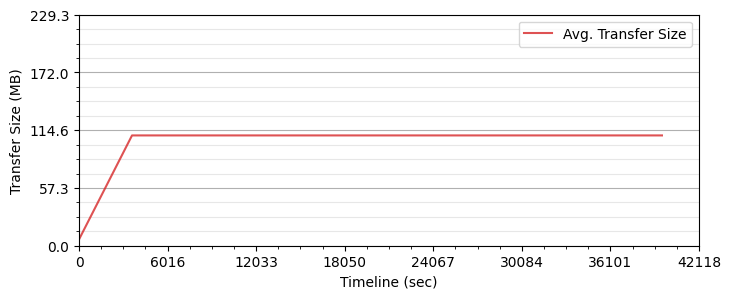

In [29]:
fig, ax = analyzer.plots.xfer_size_timeline(
    figsize=(8, 3),
    unit='mb',
    x_num_ticks=8,
)

In [30]:
fig.savefig(f'{app_name}_xfer_size.pdf', format='pdf', bbox_inches='tight')

In [ ]:
analyzer.events.query("cat == 'POSIX'").groupby("name")["size"].mean().compute() / (1024**2)

In [ ]:
analyzer.events.query("cat == 'POSIX'").groupby(["trange","pid","tid","name"])["io_time"].sum().groupby(["trange","name"]).max().groupby("name").sum().compute() / 1e6

In [ ]:
val = analyzer.events.groupby(["trange"]).agg({"io_time":[min,max],"compute_time":[min,max],"app_io_time":[min,max]}).sum().compute()
val

In [ ]:
val = analyzer.events["app_io_time"].max().compute()
val

In [ ]:
import dask
val1, val2 = dask.compute(analyzer.events["ts"].min() /1e6 , analyzer.events["ts"].max()/1e6)
val2 - val1

In [ ]:
analyzer.events["hostname"].unique().compute()[:2]

In [ ]:
analyzer.events.query("cat == 'POSIX'").groupby(["trange","name"])["dur"].max().sum().compute() / 1e6

In [ ]:
analyzer.events.query("name == 'open'").groupby("trange")["dur"].max().sum().compute() / 1e6

In [ ]:
analyzer.events.groupby(["cat","name"])["dur"].sum().compute()

In [ ]:
3766287/3.8/1e6, 1022647/3.8/1e6, 1080267/3.8/1e6, 178451/3.8/1e6, (1259124+153089)/3.8/1e6

In [ ]:
analyzer.plots.bottleneck_timeline(figsize=(8, 4))

In [ ]:
analyzer.plots.bw_timeline(figsize=(4, 4), unit='KB')

In [ ]:
analyzer.plots.xfer_size_distribution(figsize=(4, 4))